In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from collections import Counter

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('./fer2013/fer2013.csv')
df.sample(5)

,emotion,pixels,Usage
1362,4,119 88 67 63 57 53 49 57 64 91 124 135 149 160...,Training
16693,3,151 155 157 154 153 148 144 142 141 128 133 13...,Training
20012,3,237 236 238 235 198 202 204 197 197 197 198 19...,Training
27076,3,240 240 240 240 240 240 240 240 240 240 238 23...,Training
13076,3,24 26 22 16 17 20 25 46 74 98 131 145 151 154 ...,Training


In [3]:
def error_rate(pred, target):
    return np.mean(pred!=target)

In [4]:
def classification_rate(p, t):
    return np.mean(p == t)

In [5]:
def ohe(labels):
    ohe_lab = np.zeros((labels.shape[0], len(set(labels))))
    for i in range(len(labels)):
        ohe_lab[i, labels[i]] = 1
    return ohe_lab     

In [6]:
def rearrange(X):
    return (X.transpose(0, 2, 3, 1) / 255).astype(np.float32)

In [7]:
Y_all = df['emotion'].astype(int)
X_all = []
for i in df['pixels']:
    X_all.append([int(p) for p in i.split()]) #acts like getData()
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_all = np.reshape(X_all, (X_all.shape[0], 1, 48, 48)) #acts like getImageData()

In [8]:
from collections import Counter
Counter(Y_all)

Counter({0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6077, 5: 4002, 6: 6198})

In [9]:
X = rearrange(X_all)
Y = ohe(Y_all)

In [10]:
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

(35887, 48, 48, 1)
<class 'numpy.ndarray'>
(35887, 7)
<class 'numpy.ndarray'>


In [11]:
# print(X[0].shape)
# X[0]

In [12]:
max_iter = 50
print_period = 20
lr = 1e-5
reg = 1e-2

In [13]:
X_train = X[:-1000]
Y_train = Y[:-1000]
X_test = X[-1000:]
Y_test = Y[-1000:]

In [14]:
N = X_train.shape[0]
batch_size = 100
num_batches = N//batch_size

In [15]:
# get TF variables for the inputs, X and targets T
ftX = tf.placeholder(tf.float32, shape=(None, 48, 48, 1), name='X')
ftT = tf.placeholder(tf.float32, shape=(None, 7), name='T')

In [16]:
conv1_layer = tf.layers.conv2d(ftX, filters=16, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=True, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer, pool_size=2, strides=2)
conv2_layer = tf.layers.conv2d(conv1_layer_mpool, filters=32, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=True, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer, pool_size=2, strides=2)
conv3_layer = tf.layers.conv2d(conv2_layer_mpool, filters=64, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=True, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer, pool_size=2, strides=2)

Z3_shape = conv3_layer_mpool.get_shape().as_list()
Z3_r = tf.reshape(conv3_layer_mpool, [-1, np.prod(Z3_shape[1:])])

dense1_layer = tf.layers.dense(inputs=Z3_r, units=2000, use_bias=True, activation=None)
dense1_layer_activated = tf.nn.relu(dense1_layer)
dense2_layer = tf.layers.dense(inputs=dense1_layer_activated, units=1000, use_bias=True, activation=None)
dense2_layer_activated = tf.nn.relu(dense2_layer)
dense3_layer = tf.layers.dense(inputs=dense2_layer_activated, units=500, use_bias=True, activation=None)
dense3_layer_activated = tf.nn.relu(dense3_layer)

# Output Layer 
Yish = tf.layers.dense(inputs=dense3_layer_activated, units=7, activation=None)

In [17]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ftT, logits=Yish))

In [18]:
pred = tf.argmax(Yish, 1)

In [19]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.999, momentum=0.99).minimize(cost)

In [20]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(max_iter):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(num_batches):
            X_batch = X_train[(j*batch_size):(j*batch_size+batch_size)]
            Y_batch = Y_train[(j*batch_size):(j*batch_size+batch_size)]
        
            sess.run(train_op, feed_dict = {ftX: X_batch, ftT: Y_batch})
            if j % print_period == 0:
                cost_val = sess.run(cost, feed_dict={ftX: X_test, ftT: Y_test})
                pred_val = sess.run(pred, feed_dict={ftX: X_test})
                err = error_rate(pred_val, Y_test.argmax(axis = 1))
                print(i,j,cost_val,err)
                LL.append(cost_val)
                error.append(err)

0 0 1.9497118 0.857
0 20 1.9491922 0.857
0 40 1.9478853 0.857
0 60 1.9459448 0.86
0 80 1.943524 0.848
0 100 1.9407564 0.798
0 120 1.9377177 0.778
0 140 1.9345098 0.784
0 160 1.931188 0.783
0 180 1.9277654 0.78
0 200 1.9243464 0.78
0 220 1.9208835 0.78
0 240 1.9173832 0.78
0 260 1.9138416 0.78
0 280 1.9102782 0.78
0 300 1.9067008 0.78
0 320 1.9031463 0.78
0 340 1.8995857 0.78
1 0 1.8981752 0.78
1 20 1.8946686 0.78
1 40 1.8912134 0.78
1 60 1.8877963 0.78
1 80 1.8844318 0.78
1 100 1.8811257 0.78
1 120 1.8778806 0.78
1 140 1.8747426 0.78
1 160 1.8717096 0.78
1 180 1.868834 0.78
1 200 1.8661559 0.78
1 220 1.8636769 0.78
1 240 1.8614088 0.78
1 260 1.859344 0.78
1 280 1.8574717 0.78
1 300 1.8558297 0.78
1 320 1.8542588 0.78
1 340 1.8528684 0.78
2 0 1.852342 0.78
2 20 1.8511223 0.78
2 40 1.8498274 0.78
2 60 1.8484287 0.78
2 80 1.8470093 0.78
2 100 1.8454969 0.78
2 120 1.8439717 0.78
2 140 1.8424878 0.78
2 160 1.8409916 0.78
2 180 1.8394282 0.78
2 200 1.8379114 0.78
2 220 1.8364931 0.78
2 240 1

21 20 1.536981 0.606
21 40 1.5162393 0.582
21 60 1.5062418 0.599
21 80 1.5043758 0.583
21 100 1.523851 0.595
21 120 1.5123892 0.587
21 140 1.5214497 0.6
21 160 1.5036616 0.589
21 180 1.5090334 0.596
21 200 1.5069839 0.575
21 220 1.4945843 0.588
21 240 1.4919506 0.587
21 260 1.4918978 0.579
21 280 1.4898281 0.577
21 300 1.4710276 0.575
21 320 1.470536 0.572
21 340 1.4897829 0.588
22 0 1.4901832 0.581
22 20 1.4888939 0.579
22 40 1.4863559 0.565
22 60 1.4820209 0.56
22 80 1.5114477 0.611
22 100 1.48012 0.579
22 120 1.4621704 0.553
22 140 1.470968 0.566
22 160 1.4565479 0.557
22 180 1.4788151 0.58
22 200 1.505812 0.588
22 220 1.5032802 0.601
22 240 1.5119516 0.595
22 260 1.4912801 0.594
22 280 1.4678713 0.561
22 300 1.471671 0.573
22 320 1.4888098 0.582
22 340 1.4606516 0.569
23 0 1.4740814 0.568
23 20 1.4575886 0.557
23 40 1.5189021 0.58
23 60 1.4800073 0.568
23 80 1.4522406 0.56
23 100 1.4767512 0.593
23 120 1.5006908 0.586
23 140 1.4541827 0.562
23 160 1.4514625 0.549
23 180 1.4458965 0

41 160 2.4676206 0.442
41 180 2.7440963 0.467
41 200 2.785155 0.475
41 220 2.5731127 0.473
41 240 2.61954 0.463
41 260 2.5425344 0.482
41 280 2.5370772 0.478
41 300 2.488852 0.469
41 320 2.53239 0.47
41 340 2.6227376 0.459
42 0 2.599732 0.449
42 20 2.64994 0.473
42 40 2.7837768 0.479
42 60 2.7578328 0.47
42 80 2.6189802 0.48
42 100 2.6414855 0.454
42 120 2.6608086 0.458
42 140 2.629329 0.45
42 160 2.6591332 0.458
42 180 2.6398373 0.465
42 200 2.6641073 0.464
42 220 2.6887784 0.465
42 240 2.6694694 0.462
42 260 2.7198818 0.461
42 280 2.6701243 0.448
42 300 2.5797923 0.461
42 320 2.6658056 0.474
42 340 2.646709 0.465
43 0 2.5745995 0.474
43 20 2.6438363 0.468
43 40 2.7155952 0.467
43 60 2.6954842 0.483
43 80 2.8176785 0.48
43 100 2.7863164 0.478
43 120 2.8897579 0.471
43 140 2.8813381 0.474
43 160 2.870934 0.468
43 180 2.805552 0.454
43 200 2.9350712 0.459
43 220 2.8616724 0.465
43 240 2.8074949 0.465
43 260 2.7127352 0.476
43 280 2.691415 0.47
43 300 2.7366567 0.462
43 320 2.6917763 0.4

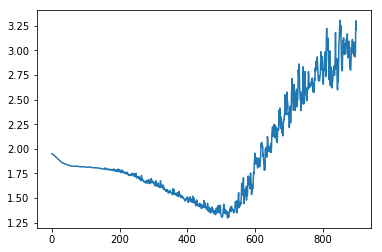

In [21]:
plt.plot(LL)
plt.show()

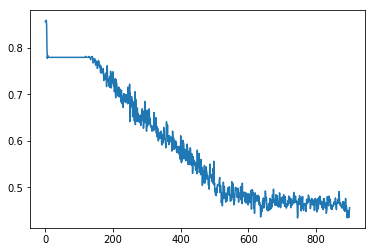

In [22]:
plt.plot(error)
plt.show()